In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro, boxcox, ttest_ind, mannwhitneyu, pearsonr, friedmanchisquare, kruskal, kstest, \
    lognorm, gamma, weibull_min, probplot, f_oneway, linregress, norm, spearmanr, ttest_1samp, wilcoxon 
import seaborn as sns
import os
import ast
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
import itertools

In [2]:
input_dir = "Results" # input directory

number = "L" # results to analyze (subfolder name, can be an integer or string)

recording_order = (15, 2, 1, 6, 10, 4)

In [3]:
dfs = {}

results_dir = os.path.join(input_dir, str(number))
files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls')) and not file.startswith('OVERVIEW')]

for file in files:
    file_path = os.path.join(results_dir, file)
    dfs[file.split('.')[0]] = pd.read_excel(file_path)

framenames = list(dfs.keys())
results = framenames[0]
results_mtt = framenames[1]
results_tt = framenames[2]

print(f"Found {framenames} in {results_dir}.")

framenames.append('RESULTS_MERGED')
framenames.append('RESUlTS_MERGED_MTT')
framenames.append('RESULTS_MERGED_TT')

Found ['RESULTS', 'RESULTS_MTT', 'RESULTS_TT'] in Results\L.


In [4]:
experiments = dfs[results]['experiment'].unique().tolist()
variables = dfs[results].columns[4:].tolist()
parameters = dfs[results].columns[:4].tolist()
print(f"Found {len(experiments)} experiments, {len(variables)} variables and {len(parameters)} parameters:")
print(" "+', '.join(experiments))
print(" "+', '.join(variables))
print(" "+', '.join(parameters))

Found 8 experiments, 7 variables and 4 parameters:
 ASR_control, gap_depth, tone_in_noise, gap_duration_4, gap_duration_8, gap_duration_10, gap_duration_20, gap_duration_50
 reactionTime, peakTime, difference, peakValue, RMS, tau, AUC
 animal, sex, date, experiment


In [5]:
def average_list_columns(df):
    df_copy = df.copy()
    for col in df_copy.columns:
        # Try to convert string representations of lists to actual lists
        if df_copy[col].apply(lambda x: isinstance(x, list) or (isinstance(x, str) and x.startswith('['))).any():
            df_copy[col] = df_copy[col].apply(
                lambda x: np.mean(ast.literal_eval(x)) if isinstance(x, str) and x.startswith('[') else np.mean(x) if isinstance(x, list) else x
            )
    return df_copy

# Create merged DataFrames with averaged values
dfs['RESULTS_MERGED'] = average_list_columns(dfs[results])
dfs['RESULTS_MTT_MERGED'] = average_list_columns(dfs[results_mtt])
dfs['RESULTS_TT_MERGED'] = average_list_columns(dfs[results_tt])

In [6]:
def average_across_dates(df):
    # Group by all columns except 'date' and the variables, then average variables across dates
    group_cols = [col for col in df.columns if col not in variables and col != 'date']
    averaged = df.groupby(group_cols, as_index=False)[variables].mean()
    return averaged

# Create merged DataFrames with averaged values
dfs['RESULTS_MERGED'] = average_list_columns(dfs[results])
dfs['RESULTS_MTT_MERGED'] = average_list_columns(dfs[results_mtt])
dfs['RESULTS_TT_MERGED'] = average_list_columns(dfs[results_tt])

# Create date-averaged versions of each merged DataFrame
dfs['RESULTS_MERGED_DATE'] = average_across_dates(dfs['RESULTS_MERGED'])
dfs['RESULTS_MTT_MERGED_DATE'] = average_across_dates(dfs['RESULTS_MTT_MERGED'])
dfs['RESULTS_TT_MERGED_DATE'] = average_across_dates(dfs['RESULTS_TT_MERGED'])

In [7]:
print(list(dfs.keys()))

['RESULTS', 'RESULTS_MTT', 'RESULTS_TT', 'RESULTS_MERGED', 'RESULTS_MTT_MERGED', 'RESULTS_TT_MERGED', 'RESULTS_MERGED_DATE', 'RESULTS_MTT_MERGED_DATE', 'RESULTS_TT_MERGED_DATE']


# Distributions

In [8]:
non_parametric_dfs = {}
for name, df in dfs.items():
    print(name)
    if not name.endswith('_MERGED'):
        continue  # Only process merged dataframes
    non_parametric = pd.DataFrame(columns=['experiment', 'var'])
    not_enough_data = 0
    for var in variables:
        for exp in experiments:
            for sex in ['male', 'female']:
                data = df[(df['sex'] == sex) & (df['experiment'] == exp)][var].dropna()
                if len(data) > 2:
                    stat, p = shapiro(data)
                    if p < 0.05:
                        non_parametric = pd.concat(
                            [non_parametric, pd.DataFrame({'experiment': [exp], 'var': [var]})],
                            ignore_index=True
                        )
                else:
                    not_enough_data += 1
    non_parametric_dfs[name] = non_parametric
    #print(f"Non-parametric entries in {name}: {len(non_parametric)}")
    #if not_enough_data != 0: print(f"Warning, not enough data for {not_enough_data} entries.")

RESULTS
RESULTS_MTT
RESULTS_TT
RESULTS_MERGED
RESULTS_MTT_MERGED
RESULTS_TT_MERGED
RESULTS_MERGED_DATE
RESULTS_MTT_MERGED_DATE
RESULTS_TT_MERGED_DATE


c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [9]:
print(len(non_parametric_dfs['RESULTS_MERGED']))
print(len(non_parametric_dfs['RESULTS_MTT_MERGED']))
print(len(non_parametric_dfs['RESULTS_TT_MERGED']))

20
20
22


### Expand non-parametric tests to all variations of gap duration or offset PPI if one of the variations shows significant deviations from normality

In [10]:
gap_durations = ['gap_duration_4', 'gap_duration_8', 'gap_duration_10', 'gap_duration_20', 'gap_duration_50']
offset_exps = [exp for exp in dfs[results]['experiment'].unique() if 'offset_PPI' in str(exp).lower()]

# Concatenate and drop duplicates as before
dfs_to_merge = [
    non_parametric_dfs['RESULTS_MERGED'],
    non_parametric_dfs['RESULTS_MTT_MERGED'],
    non_parametric_dfs['RESULTS_TT_MERGED']
]
non_parametric = pd.concat(dfs_to_merge, ignore_index=True).drop_duplicates()

# Extend: for each row with "gap_duration" in experiment, add all gap_duration_* for that var
rows_to_add = []
for _, row in non_parametric.iterrows():
    if "gap_duration" in row['experiment']:
        for gap_exp in gap_durations:
            if gap_exp != row['experiment']:
                new_row = row.copy()
                new_row['experiment'] = gap_exp
                rows_to_add.append(new_row)
    if "offset_PPI" in row['experiment']:
        for offset_exp in offset_exps:
            if offset_exp != row['experiment']:
                new_row = row.copy()
                new_row['experiment'] = offset_exp
                rows_to_add.append(new_row)


# Add the new rows and drop duplicates again
if rows_to_add:
    non_parametric = pd.concat([non_parametric, pd.DataFrame(rows_to_add)], ignore_index=True).drop_duplicates()

print(non_parametric)

         experiment           var
0       ASR_control  reactionTime
1    gap_duration_4  reactionTime
2    gap_duration_8  reactionTime
3   gap_duration_10  reactionTime
4   gap_duration_50  reactionTime
5       ASR_control      peakTime
6         gap_depth      peakTime
7     tone_in_noise      peakTime
8    gap_duration_4      peakTime
9    gap_duration_8      peakTime
10  gap_duration_10      peakTime
11  gap_duration_20      peakTime
12  gap_duration_50      peakTime
13      ASR_control    difference
14  gap_duration_20    difference
15  gap_duration_50    difference
16        gap_depth           AUC
17        gap_depth           RMS
18        gap_depth  reactionTime
19    tone_in_noise  reactionTime
20  gap_duration_20  reactionTime
21        gap_depth    difference
22  gap_duration_10    difference
23   gap_duration_4           tau
24  gap_duration_10           AUC
61   gap_duration_4    difference
62   gap_duration_8    difference
77   gap_duration_8           tau
78  gap_durati

---

In [11]:
def compare_metrics(df1, df2, variables, group_cols=None, test='auto', non_parametric=None, alpha=0.05, include_all=False):
    """
    Compare all metrics (variables) in df1 to df2.
    If group_cols is provided, compare within each group.
    test: 'auto' (choose t-test or Mann-Whitney based on normality or non_parametric list), 'ttest', or 'mannwhitney'
    non_parametric: DataFrame with columns ['experiment', 'var'] indicating which (experiment, variable) pairs to use non-parametric test for.
    alpha: significance threshold for p-value.
    include_all: if True, include non-significant results in output. Default False.
    Returns a DataFrame with results.
    """
    results = []
    if group_cols is None:
        group_cols = []
    for var in variables:
        if group_cols:
            groups = df1[group_cols].drop_duplicates()
            for _, group_vals in groups.iterrows():
                group_dict = group_vals.to_dict()
                mask1 = np.ones(len(df1), dtype=bool)
                mask2 = np.ones(len(df2), dtype=bool)
                for col in group_cols:
                    mask1 &= (df1[col] == group_dict[col])
                    mask2 &= (df2[col] == group_dict[col])
                vals1 = df1.loc[mask1, var].dropna()
                vals2 = df2.loc[mask2, var].dropna()
                if len(vals1) < 2 or len(vals2) < 2:
                    continue
                is_non_parametric = False
                if non_parametric is not None:
                    experiment = group_dict['experiment'] if 'experiment' in group_cols else None
                    if experiment is not None:
                        is_non_parametric = ((non_parametric['experiment'] == experiment) & (non_parametric['var'] == var)).any()
                if test == 'auto':
                    if is_non_parametric:
                        stat, p = mannwhitneyu(vals1, vals2)
                        test_used = 'mannwhitney'
                    else:
                        stat, p = ttest_ind(vals1, vals2)
                        test_used = 'ttest'
                elif test == 'ttest':
                    stat, p = ttest_ind(vals1, vals2)
                    test_used = 'ttest'
                else:
                    stat, p = mannwhitneyu(vals1, vals2)
                    test_used = 'mannwhitney'
                if p < alpha or include_all:
                    results.append({**group_dict, 'variable': var, 'stat': stat, 'p': p, 'test': test_used, 'significant': p < alpha})
        else:
            vals1 = df1[var].dropna()
            vals2 = df2[var].dropna()
            if len(vals1) < 2 or len(vals2) < 2:
                continue
            is_non_parametric = False
            if non_parametric is not None:
                is_non_parametric = (non_parametric['var'] == var).any()
            if test == 'auto':
                if is_non_parametric:
                    stat, p = mannwhitneyu(vals1, vals2)
                    test_used = 'mannwhitney'
                else:
                    stat, p = ttest_ind(vals1, vals2)
                    test_used = 'ttest'
            elif test == 'ttest':
                stat, p = ttest_ind(vals1, vals2)
                test_used = 'ttest'
            else:
                stat, p = mannwhitneyu(vals1, vals2)
                test_used = 'mannwhitney'
            if p < alpha or include_all:
                results.append({'variable': var, 'stat': stat, 'p': p, 'test': test_used, 'significant': p < alpha})
    return pd.DataFrame(results)

In [12]:
comparison_df_date = compare_metrics(
    dfs['RESULTS_MTT_MERGED_DATE'],
    dfs['RESULTS_TT_MERGED_DATE'],
    variables,
    group_cols=['experiment'],
    non_parametric=non_parametric,
    include_all=False
)
print(comparison_df_date) if not comparison_df_date.empty else print("No significant differences found for date-averaged comparison.")

       experiment      variable  stat         p         test  significant
0  gap_duration_4  reactionTime  27.5  0.016887  mannwhitney         True
1  gap_duration_8           tau  28.0  0.017316  mannwhitney         True


In [13]:
# Run post hoc Dunn's test for each significant experiment/variable pair

import scikit_posthocs as sp

# Filter significant pairs from previous comparison
significant_pairs = comparison_df_date[['experiment', 'variable']]

posthoc_results = []

for _, row in significant_pairs.iterrows():
    exp = row['experiment']
    var = row['variable']
    # Combine TT and MTT data for the experiment
    df_tt = dfs['RESULTS_TT_MERGED_DATE']
    df_mtt = dfs['RESULTS_MTT_MERGED_DATE']
    data_tt = df_tt[df_tt['experiment'] == exp][var].dropna()
    data_mtt = df_mtt[df_mtt['experiment'] == exp][var].dropna()
    data = pd.DataFrame({
        var: pd.concat([data_tt, data_mtt]),
        'group': ['TT'] * len(data_tt) + ['MTT'] * len(data_mtt)
    })
    # Dunn's test
    dunn = sp.posthoc_dunn(data, val_col=var, group_col='group', p_adjust='bonferroni')
    posthoc_results.append({'experiment': exp, 'variable': var, 'dunn_p': dunn.loc['TT', 'MTT']})

posthoc_df = pd.DataFrame(posthoc_results)
print(posthoc_df)

       experiment      variable    dunn_p
0  gap_duration_4  reactionTime  0.012821
1  gap_duration_8           tau  0.017622


In [14]:
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std if pooled_std > 0 else np.nan

def rank_biserial(x, y):
    from scipy.stats import mannwhitneyu
    u, _ = mannwhitneyu(x, y, alternative='two-sided')
    n1, n2 = len(x), len(y)
    return 1 - (2 * u) / (n1 * n2)

print("Effect strength for each significant experiment-variable pair (TT vs MTT):")
for _, row in posthoc_df.iterrows():
    exp = row['experiment']
    var = row['variable']
    data_tt = dfs['RESULTS_TT_MERGED_DATE'][dfs['RESULTS_TT_MERGED_DATE']['experiment'] == exp][var].dropna()
    data_mtt = dfs['RESULTS_MTT_MERGED_DATE'][dfs['RESULTS_MTT_MERGED_DATE']['experiment'] == exp][var].dropna()
    test_row = comparison_df_date[(comparison_df_date['experiment'] == exp) & (comparison_df_date['variable'] == var)]
    test_type = test_row['test'].values[0] if not test_row.empty else 'ttest'
    if test_type == 'ttest':
        eff = cohen_d(data_tt, data_mtt)
        eff_label = "Cohen's d"
    else:
        eff = rank_biserial(data_tt, data_mtt)
        eff_label = "Rank-biserial"
    print(f"{exp} / {var}: {eff_label} = {eff:.3f}")

Effect strength for each significant experiment-variable pair (TT vs MTT):
gap_duration_4 / reactionTime: Rank-biserial = 0.833
gap_duration_8 / tau: Rank-biserial = 0.867


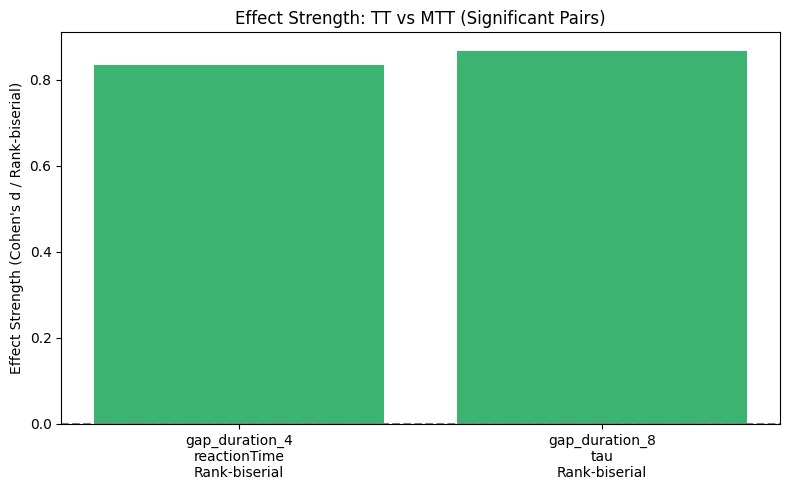

In [15]:
import matplotlib.pyplot as plt

# Collect effect strengths for plotting
effect_labels = []
effect_values = []

for _, row in posthoc_df.iterrows():
    exp = row['experiment']
    var = row['variable']
    data_tt = dfs['RESULTS_TT_MERGED_DATE'][dfs['RESULTS_TT_MERGED_DATE']['experiment'] == exp][var].dropna()
    data_mtt = dfs['RESULTS_MTT_MERGED_DATE'][dfs['RESULTS_MTT_MERGED_DATE']['experiment'] == exp][var].dropna()
    test_row = comparison_df_date[(comparison_df_date['experiment'] == exp) & (comparison_df_date['variable'] == var)]
    test_type = test_row['test'].values[0] if not test_row.empty else 'ttest'
    if test_type == 'ttest':
        eff = cohen_d(data_tt, data_mtt)
        eff_label = "Cohen's d"
    else:
        eff = rank_biserial(data_tt, data_mtt)
        eff_label = "Rank-biserial"
    effect_labels.append(f"{exp}\n{var}\n{eff_label}")
    effect_values.append(eff)

if effect_values:
    plt.figure(figsize=(8, 5))
    plt.bar(effect_labels, effect_values, color='mediumseagreen')
    plt.axhline(0, color='gray', linestyle='--')
    plt.ylabel("Effect Strength (Cohen's d / Rank-biserial)")
    plt.title("Effect Strength: TT vs MTT (Significant Pairs)")
    plt.tight_layout()
    plt.show()
else:
    raise ValueError("No effect strength values found, cannot plot.")

### Effect Strength for Significant TT vs MTT Pairs

| Experiment      | Variable      | Effect Strength | Value   | Interpretation                                  |
|-----------------|--------------|-----------------|---------|-------------------------------------------------|
| gap_duration_4  | reactionTime | Rank-biserial   | 0.833   | Strong effect; TT and MTT groups are well separated for reaction time in gap_duration_4 |
| gap_duration_8  | tau          | Rank-biserial   | 0.867   | Strong effect; TT and MTT groups are well separated for tau in gap_duration_8           |

**Summary:**  
Only a small subset of experiment-variable pairs show significant differences between TT and MTT. Most pairs do not, and as such there is no evidence for a general or systematic difference between the two dataframes.

---

In [16]:
comparison_df_date = compare_metrics(
    dfs['RESULTS_MTT_MERGED'],
    dfs['RESULTS_MTT_MERGED_DATE'],
    variables,
    group_cols=['experiment'],
    non_parametric=non_parametric,
    include_all=True
)
print(comparison_df_date) if not comparison_df_date.empty else print("No significant differences found for date-averaged comparison.")

         experiment      variable          stat         p         test  \
0       ASR_control  reactionTime  4.650000e+01  0.636151  mannwhitney   
1         gap_depth  reactionTime  5.450000e+01  1.000000  mannwhitney   
2     tone_in_noise  reactionTime  5.700000e+01  0.867547  mannwhitney   
3    gap_duration_4  reactionTime  4.350000e+01  0.488664  mannwhitney   
4    gap_duration_8  reactionTime  5.050000e+01  0.835401  mannwhitney   
5   gap_duration_10  reactionTime  5.000000e+01  0.812019  mannwhitney   
6   gap_duration_20  reactionTime  5.550000e+01  0.945826  mannwhitney   
7   gap_duration_50  reactionTime  4.450000e+01  0.532966  mannwhitney   
8       ASR_control      peakTime  5.100000e+01  0.867318  mannwhitney   
9         gap_depth      peakTime  3.750000e+01  0.279008  mannwhitney   
10    tone_in_noise      peakTime  5.150000e+01  0.886584  mannwhitney   
11   gap_duration_4      peakTime  6.000000e+01  0.708613  mannwhitney   
12   gap_duration_8      peakTime  3.7

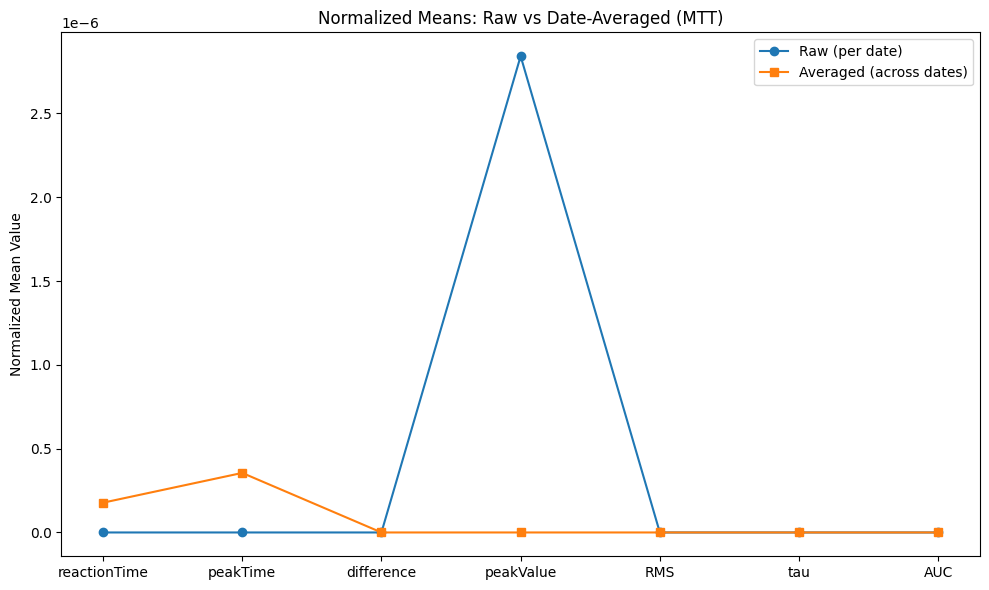

In [17]:
import matplotlib.pyplot as plt

# Compare each variable before and after date averaging (MTT only)
df_raw = dfs['RESULTS_MTT_MERGED']
df_avg = dfs['RESULTS_MTT_MERGED_DATE']

mean_raw = df_raw[variables].mean()
mean_avg = df_avg[variables].mean()

# Normalize both to [0, 1] for each variable
min_vals = np.minimum(mean_raw, mean_avg)
max_vals = np.maximum(mean_raw, mean_avg)
norm_raw = (mean_raw - min_vals) / (max_vals - min_vals + 1e-8)
norm_avg = (mean_avg - min_vals) / (max_vals - min_vals + 1e-8)

plt.figure(figsize=(10, 6))
plt.plot(variables, norm_raw, marker='o', label='Raw (per date)')
plt.plot(variables, norm_avg, marker='s', label='Averaged (across dates)')
plt.ylabel('Normalized Mean Value')
plt.title('Normalized Means: Raw vs Date-Averaged (MTT)')
plt.legend()
plt.tight_layout()
plt.show()

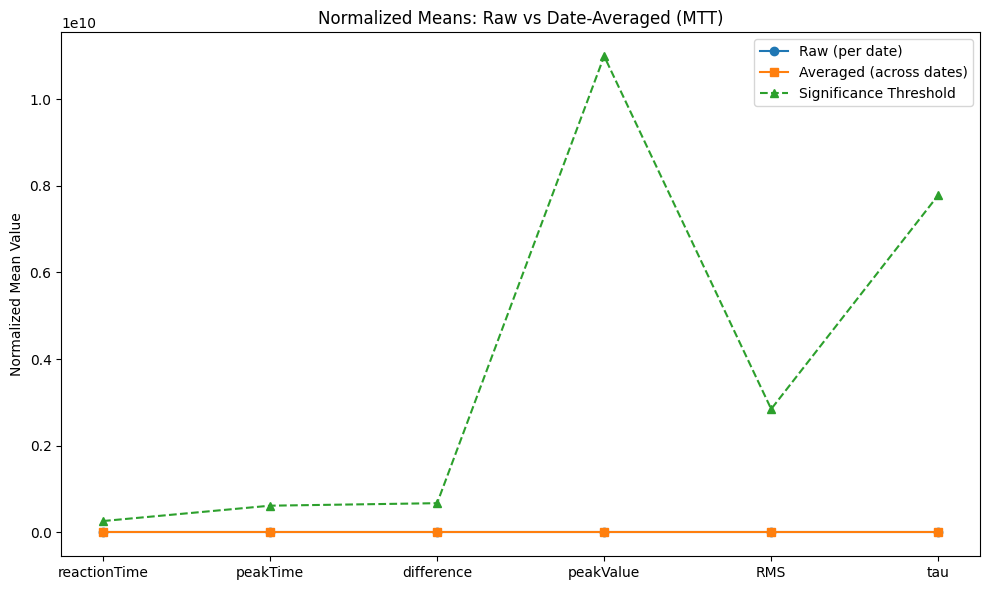

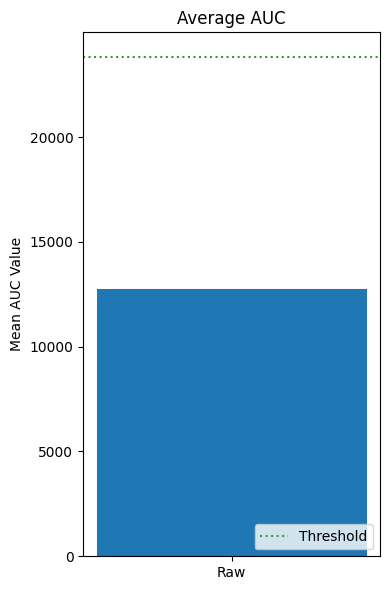

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Exclude 'auc' from variables
plot_variables = [v for v in variables if v.lower() != 'auc']

# Compare each variable before and after date averaging (MTT only)
df_raw = dfs['RESULTS_MTT_MERGED']
df_avg = dfs['RESULTS_MTT_MERGED_DATE']

mean_raw = df_raw[plot_variables].mean()
mean_avg = df_avg[plot_variables].mean()

# Normalize both to [0, 1] for each variable
min_vals = np.minimum(mean_raw, mean_avg)
max_vals = np.maximum(mean_raw, mean_avg)
norm_raw = (mean_raw - min_vals) / (max_vals - min_vals + 1e-8)
norm_avg = (mean_avg - min_vals) / (max_vals - min_vals + 1e-8)

# Calculate threshold mean value for significance (example: mean_raw + 2*std)
# Replace with your actual significance calculation if needed
stds = df_raw[plot_variables].std()
threshold_mean = mean_raw + 2 * stds
norm_threshold = (threshold_mean - min_vals) / (max_vals - min_vals + 1e-8)

plt.figure(figsize=(10, 6))
plt.plot(plot_variables, norm_raw, marker='o', label='Raw (per date)')
plt.plot(plot_variables, norm_avg, marker='s', label='Averaged (across dates)')
plt.plot(plot_variables, norm_threshold, marker='^', linestyle='--', label='Significance Threshold')
plt.ylabel('Normalized Mean Value')
plt.title('Normalized Means: Raw vs Date-Averaged (MTT)')
plt.legend()
plt.tight_layout()
plt.show()


# Separate bar plot for 'auc' (threshold as dotted line)
auc_col = next((col for col in df_raw.columns if col.lower() == 'auc'), None)
if auc_col is not None:
    auc_raw = df_raw[auc_col].mean()
    auc_stds = df_raw[auc_col].std()
    auc_threshold = auc_raw + 2 * auc_stds
    plt.figure(figsize=(4, 6))
    plt.bar(['Raw'], [auc_raw], color=['C0'])
    plt.axhline(auc_threshold, color='C2', linestyle=':', label='Threshold')
    plt.ylabel('Mean AUC Value')
    plt.title('Average AUC')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
else:
    print("AUC column not found in the dataframes.")

im tired so everything above is probably not making a whole lot of sense

In [19]:
import pandas as pd
import scikit_posthocs as sp
from scipy.stats import kruskal

# Load the merged results DataFrame
df = dfs['RESULTS_MTT_MERGED']

# List your metrics (adjust as needed)
metrics = ['peakValue', 'RMS', 'tau', 'AUC', 'reactionTime', 'peakTime', 'difference']

# Average across experiments for each animal, date, and sex
grouped = df.groupby(['animal', 'date', 'sex'])[metrics].mean().reset_index()

print("Significant differences between dates (averaged across experiments):")
for var in metrics:
    if var not in grouped.columns:
        continue
    # Prepare groups by date
    groups = [group[var].dropna().values for _, group in grouped.groupby('date')]
    groups = [g for g in groups if len(g) > 1]
    if len(groups) < 2:
        continue
    stat, p = kruskal(*groups)
    print(f"{var}: Kruskal-Wallis p={p:.3g}")
    if p < 0.05:
        dunn = sp.posthoc_dunn(grouped, val_col=var, group_col='date', p_adjust='bonferroni')
        print("Post hoc Dunn's test p-values:")
        print(dunn)
    else:
        print(f"No significant post hoc differences for {var}.")

Significant differences between dates (averaged across experiments):
peakValue: Kruskal-Wallis p=0.325
No significant post hoc differences for peakValue.
RMS: Kruskal-Wallis p=0.331
No significant post hoc differences for RMS.
tau: Kruskal-Wallis p=0.895
No significant post hoc differences for tau.
AUC: Kruskal-Wallis p=0.196
No significant post hoc differences for AUC.
reactionTime: Kruskal-Wallis p=0.343
No significant post hoc differences for reactionTime.
peakTime: Kruskal-Wallis p=0.63
No significant post hoc differences for peakTime.
difference: Kruskal-Wallis p=0.444
No significant post hoc differences for difference.


---

In [20]:
# Test if the index within lists (i.e., trial order) affects each variable in 'RESULTS'
from scipy.stats import f_oneway, kruskal

def test_list_index_effect(df, variables, max_index=10, alpha=0.05):
    """
    For each variable, tests if the value changes significantly across list indices (trial order).
    Only prints significant results.
    """
    results = []
    for var in variables:
        # Convert string lists to actual lists if needed
        vals = df[var].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
        # Filter to rows that are lists and have enough length
        list_rows = vals[vals.apply(lambda x: isinstance(x, list) and len(x) > 1)]
        if list_rows.empty:
            raise ValueError(f"No valid list data found for variable '{var}'. Ensure all entries are lists with more than one element.")
        # Find the minimum length across all lists (to avoid index errors)
        min_len = min(list_rows.apply(len))
        min_len = min(min_len, max_index)  # Limit to max_index if desired
        # Gather values by index
        index_groups = []
        for i in range(min_len):
            group = list_rows.apply(lambda x: x[i] if len(x) > i else np.nan).dropna()
            if len(group) > 1:
                index_groups.append(group.values)
        if len(index_groups) < 2:
            raise ValueError(f"Not enough data to test index effect for variable '{var}'. Ensure each list has at least {min_len} elements.")
        # Use Kruskal-Wallis (non-parametric) or ANOVA (parametric) depending on normality
        # Here, we use Kruskal-Wallis for robustness
        stat, p = kruskal(*index_groups)
        if p < alpha:
            results.append({'variable': var, 'stat': stat, 'p': p, 'test': 'kruskal'})
    return pd.DataFrame(results)

significant_index_effects = test_list_index_effect(dfs['RESULTS_MTT'], variables)
print(significant_index_effects if not significant_index_effects.empty else "No significant index effects found for any variable.")

No significant index effects found for any variable.


### Conclusion: Average across repetitions

---

In [21]:
# Define metric groups
strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

def compare_male_female(df, metrics, alpha=0.05):
    results = []
    for var in metrics:
        if var not in df.columns:
            continue
        vals_male = df[df['sex'] == 'male'][var].dropna()
        vals_female = df[df['sex'] == 'female'][var].dropna()
        if len(vals_male) < 2 or len(vals_female) < 2:
            continue
        # Normality check
        _, p1 = shapiro(vals_male) if len(vals_male) > 3 else (None, 1)
        _, p2 = shapiro(vals_female) if len(vals_female) > 3 else (None, 1)
        if p1 < 0.05 or p2 < 0.05:
            stat, p = mannwhitneyu(vals_male, vals_female)
            test_used = 'mannwhitney'
        else:
            stat, p = ttest_ind(vals_male, vals_female)
            test_used = 'ttest'
        results.append({'variable': var, 'stat': stat, 'p': p, 'test': test_used, 'significant': p < alpha})
    return pd.DataFrame(results)

df = dfs['RESULTS_MTT_MERGED_DATE']

print("Differences between males and females (Strength Metrics):")
strength_results = compare_male_female(df, strength_metrics)
print(strength_results if not strength_results.empty else "None found.")

print("\nDifferences between males and females (Reaction Metrics):")
reaction_results = compare_male_female(df, reaction_metrics)
print(reaction_results if not reaction_results.empty else "None found.")

Differences between males and females (Strength Metrics):
    variable   stat             p         test  significant
0  peakValue  554.0  4.387047e-08  mannwhitney         True
1        RMS  504.0  8.849271e-06  mannwhitney         True
2        tau   20.0  3.472818e-08  mannwhitney         True
3        AUC  453.0  6.940145e-04  mannwhitney         True

Differences between males and females (Reaction Metrics):
       variable        stat         p         test  significant
0  reactionTime  209.500000  0.106825  mannwhitney        False
1      peakTime  226.500000  0.208168  mannwhitney        False
2    difference    0.023662  0.981225        ttest        False


In [22]:
# Post hoc Dunn's test for each metric (sex as group) after compare_male_female
import scikit_posthocs as sp

all_metrics = strength_metrics + reaction_metrics
print("\nPost hoc Dunn's test for all metrics (sex as group):")
for var in all_metrics:
    if var not in df.columns:
        continue
    # Only test if both groups have enough data
    groups = [group[var].dropna().values for _, group in df.groupby('sex')]
    groups = [g for g in groups if len(g) > 1]
    if len(groups) < 2:
        continue
    stat, p = kruskal(*groups)
    print(f"{var}: Kruskal-Wallis p={p:.3g}")
    if p < 0.05:
        dunn = sp.posthoc_dunn(df, val_col=var, group_col='sex', p_adjust='bonferroni')
        print(dunn)
        means = df.groupby('sex')[var].mean()
        print("Means by sex:", means.to_dict())
    else:
        print(f"No significant post hoc differences for {var}. Kruskal-Wallis p={p:.3g}")
#


Post hoc Dunn's test for all metrics (sex as group):
peakValue: Kruskal-Wallis p=4.14e-08
              female          male
female  1.000000e+00  4.138729e-08
male    4.138729e-08  1.000000e+00
Means by sex: {'female': 92.97152777777778, 'male': 163.9724537037037}
RMS: Kruskal-Wallis p=8.43e-06
          female      male
female  1.000000  0.000008
male    0.000008  1.000000
Means by sex: {'female': 25.47112731481481, 'male': 41.15701388888889}
tau: Kruskal-Wallis p=3.27e-08
              female          male
female  1.000000e+00  3.274894e-08
male    3.274894e-08  1.000000e+00
Means by sex: {'female': 157.98587037037038, 'male': 119.74973611111112}
AUC: Kruskal-Wallis p=0.000668
          female      male
female  1.000000  0.000668
male    0.000668  1.000000
Means by sex: {'female': 10410.28388888889, 'male': 15062.515150462963}
reactionTime: Kruskal-Wallis p=0.105
No significant post hoc differences for reactionTime. Kruskal-Wallis p=0.105
peakTime: Kruskal-Wallis p=0.204
No signifi

In [23]:
# Effect strength calculation for sex differences (for all significant metrics)

eff_str = {}

def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std if pooled_std > 0 else np.nan

def rank_biserial(x, y):
    from scipy.stats import mannwhitneyu
    u, _ = mannwhitneyu(x, y, alternative='two-sided')
    n1, n2 = len(x), len(y)
    return 1 - (2 * u) / (n1 * n2)

print("Effect strength for each significant metric (male vs female):")
for var in strength_metrics + reaction_metrics:
    if var not in df.columns:
        continue
    vals_male = df[df['sex'] == 'male'][var].dropna()
    vals_female = df[df['sex'] == 'female'][var].dropna()
    if len(vals_male) < 2 or len(vals_female) < 2:
        continue
    # Use test type from previous results if available, otherwise default to Mann-Whitney for non-normal
    _, p1 = shapiro(vals_male) if len(vals_male) > 3 else (None, 1)
    _, p2 = shapiro(vals_female) if len(vals_female) > 3 else (None, 1)
    if p1 < 0.05 or p2 < 0.05:
        eff = rank_biserial(vals_male, vals_female)
        eff_label = "Rank-biserial"
    else:
        eff = cohen_d(vals_male, vals_female)
        eff_label = "Cohen's d"
    print(f"{var}: {eff_label} = {eff:.3f}")
    eff_str[var] = eff

Effect strength for each significant metric (male vs female):
peakValue: Rank-biserial = -0.924
RMS: Rank-biserial = -0.750
tau: Rank-biserial = 0.931
AUC: Rank-biserial = -0.573
reactionTime: Rank-biserial = 0.273
peakTime: Rank-biserial = 0.214
difference: Cohen's d = 0.007


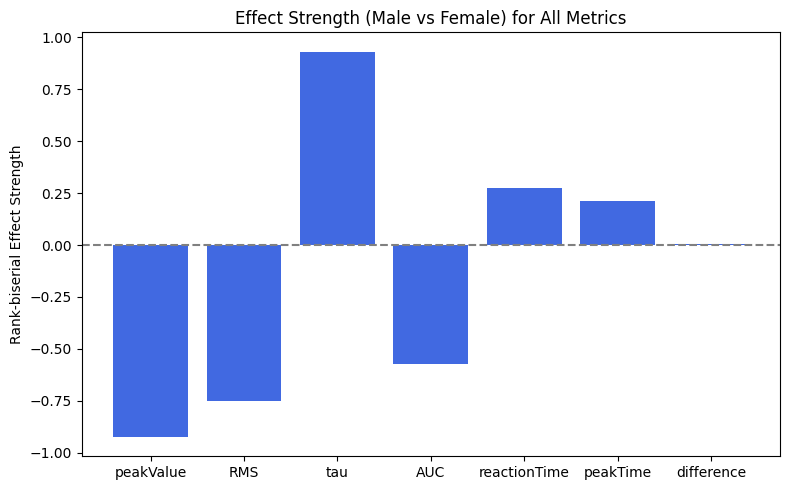

In [24]:
import matplotlib.pyplot as plt

# Effect strengths from your results
metrics = eff_str.keys()
effect_strengths = eff_str.values()

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, effect_strengths, color='royalblue')
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel("Rank-biserial Effect Strength")
plt.title("Effect Strength (Male vs Female) for All Metrics")
plt.tight_layout()

### Effect Strength for Significant Metrics (Male vs Female)

| Metric        | Effect Strength | Value   | Interpretation                                      |
|---------------|----------------|---------|-----------------------------------------------------|
| peakValue     | Rank-biserial  | -0.924  | Very strong difference; males < females              |
| RMS           | Rank-biserial  | -0.750  | Strong difference; males < females                   |
| tau           | Rank-biserial  |  0.931  | Very strong difference; males > females              |
| AUC           | Rank-biserial  | -0.573  | Moderate difference; males < females                 |
| reactionTime  | Rank-biserial  |  0.273  | Weak difference; males > females                     |
| peakTime      | Rank-biserial  |  0.214  | Very weak difference; males > females                |
| difference    | Cohen's d      |  0.007  | No meaningful difference                            |

**Summary:**  
Strong sex differences are present for peakValue, RMS, tau, and AUC. Differences for reactionTime, peakTime, and difference are weak or negligible.

### Conclusion: split by sex for strength, though ideally also for reaction time metrics

---

In [25]:
split_strength = True
split_reaction = False

In [26]:
# Compare the effect of recording_order (animal order) on strength and reaction metrics,
# using split_strength and split_reaction to control splitting by sex

strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

def extract_animal_number(animal_str):
    # Extracts the number from 'Animal15' -> 15
    if isinstance(animal_str, str) and animal_str.lower().startswith('animal'):
        return int(''.join(filter(str.isdigit, animal_str)))
    return np.nan

df = dfs['RESULTS_MTT_MERGED_DATE'].copy()
df['animal_num'] = df['animal'].apply(extract_animal_number)

# Only keep animals in the recording_order
df = df[df['animal_num'].isin(recording_order)]
df['rec_order'] = df['animal_num'].apply(lambda x: recording_order.index(x) if x in recording_order else np.nan)

def test_recording_order(df, metrics, split, metric_type):
    if split:
        print(f"Effect of recording order on {metric_type} metrics (split by sex):")
        for sex in ['male', 'female']:
            df_sex = df[df['sex'] == sex]
            for var in metrics:
                if var not in df_sex.columns:
                    raise ValueError(f"Variable '{var}' not found in DataFrame for {sex}")
                groups = [group[var].dropna().values for _, group in df_sex.groupby('rec_order')]
                groups = [g for g in groups if len(g) > 1]
                if len(groups) < 2:
                    raise ValueError(f"Not enough data to test recording order effect for variable '{var}' ({sex})")
                is_non_parametric = False
                for rec_idx, group in df_sex.groupby('rec_order'):
                    if not group.empty and 'experiment' in group.columns:
                        exp_name = group['experiment'].iloc[0]
                        if ((non_parametric['experiment'] == exp_name) & (non_parametric['var'] == var)).any():
                            is_non_parametric = True
                            break
                if is_non_parametric:
                    stat, p = kruskal(*groups)
                    test_used = "Kruskal-Wallis"
                else:
                    stat, p = f_oneway(*groups)
                    test_used = "ANOVA"
                if p < 0.05:
                    print(f"{var} ({sex}): {test_used} stat={stat:.3f}, p={p:.3g}")
    else:
        print(f"\nEffect of recording order on {metric_type} metrics (merged sexes):")
        for var in metrics:
            if var not in df.columns:
                raise ValueError(f"Variable '{var}' not found in DataFrame")
            groups = [group[var].dropna().values for _, group in df.groupby('rec_order')]
            groups = [g for g in groups if len(g) > 1]
            if len(groups) < 2:
                raise ValueError(f"Not enough data to test recording order effect for variable '{var}'")
            is_non_parametric = False
            for rec_idx, group in df.groupby('rec_order'):
                if not group.empty and 'experiment' in group.columns:
                    exp_name = group['experiment'].iloc[0]
                    if ((non_parametric['experiment'] == exp_name) & (non_parametric['var'] == var)).any():
                        is_non_parametric = True
                        break
            if is_non_parametric:
                stat, p = kruskal(*groups)
                test_used = "Kruskal-Wallis"
            else:
                stat, p = f_oneway(*groups)
                test_used = "ANOVA"
            if p < 0.05:
                print(f"{var}: {test_used} stat={stat:.3f}, p={p:.3g}")
        # Also show split by sex for reference
        print(f"\nEffect of recording order on {metric_type} metrics (split by sex):")
        for sex in ['male', 'female']:
            df_sex = df[df['sex'] == sex]
            for var in metrics:
                if var not in df_sex.columns:
                    raise ValueError(f"Variable '{var}' not found in DataFrame for {sex}")
                groups = [group[var].dropna().values for _, group in df_sex.groupby('rec_order')]
                groups = [g for g in groups if len(g) > 1]
                if len(groups) < 2:
                    raise ValueError(f"Not enough data to test recording order effect for variable '{var}' ({sex})")
                is_non_parametric = False
                for rec_idx, group in df_sex.groupby('rec_order'):
                    if not group.empty and 'experiment' in group.columns:
                        exp_name = group['experiment'].iloc[0]
                        if ((non_parametric['experiment'] == exp_name) & (non_parametric['var'] == var)).any():
                            is_non_parametric = True
                            break
                if is_non_parametric:
                    stat, p = kruskal(*groups)
                    test_used = "Kruskal-Wallis"
                else:
                    stat, p = f_oneway(*groups)
                    test_used = "ANOVA"
                if p < 0.05:
                    print(f"{var} ({sex}): {test_used} stat={stat:.3f}, p={p:.3g}")

# Run for strength and reaction metrics
test_recording_order(df, strength_metrics, split_strength, "strength")
test_recording_order(df, reaction_metrics, split_reaction, "reaction")

Effect of recording order on strength metrics (split by sex):
peakValue (male): ANOVA stat=41.200, p=5.38e-08
RMS (male): ANOVA stat=48.797, p=1.28e-08
tau (male): ANOVA stat=31.067, p=5.32e-07
AUC (male): ANOVA stat=63.110, p=1.32e-09
peakValue (female): ANOVA stat=14.251, p=0.000123
RMS (female): ANOVA stat=10.615, p=0.000652
tau (female): ANOVA stat=29.418, p=8.13e-07
AUC (female): ANOVA stat=7.937, p=0.00271

Effect of recording order on reaction metrics (merged sexes):
reactionTime: Kruskal-Wallis stat=25.225, p=0.000126
peakTime: Kruskal-Wallis stat=16.342, p=0.00593
difference: Kruskal-Wallis stat=18.237, p=0.00266

Effect of recording order on reaction metrics (split by sex):
reactionTime (male): Kruskal-Wallis stat=6.907, p=0.0316
peakTime (male): Kruskal-Wallis stat=10.554, p=0.00511
difference (male): Kruskal-Wallis stat=8.994, p=0.0111
reactionTime (female): Kruskal-Wallis stat=15.939, p=0.000346
difference (female): Kruskal-Wallis stat=7.943, p=0.0188


In [27]:
import scikit_posthocs as sp

strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

def posthoc_dunn_recording_order(df, metrics, split, metric_type):
    if split:
        print(f"Post hoc Dunn's test for {metric_type} metrics (split by sex):")
        for sex in ['male', 'female']:
            df_sex = df[df['sex'] == sex]
            for var in metrics:
                if var not in df_sex.columns:
                    raise ValueError(f"Variable '{var}' not found in DataFrame for {sex}")
                groups = [group[var].dropna().values for _, group in df_sex.groupby('rec_order')]
                groups = [g for g in groups if len(g) > 1]
                if len(groups) < 2:
                    raise ValueError(f"Not enough data to perform Dunn's test for {var} ({sex})")
                stat, p = kruskal(*groups)
                if p < 0.05:
                    dunn = sp.posthoc_dunn(df_sex, val_col=var, group_col='rec_order', p_adjust='bonferroni')
                    print(f"\n{var} ({sex}):")
                    print(dunn)
                    means = df_sex.groupby('rec_order')[var].mean()
                    print("Means by rec_order:", means.to_dict())
    else:
        print(f"\nPost hoc Dunn's test for {metric_type} metrics (merged sexes):")
        for var in metrics:
            if var not in df.columns:
                raise ValueError(f"Variable '{var}' not found in DataFrame")
            groups = [group[var].dropna().values for _, group in df.groupby('rec_order')]
            groups = [g for g in groups if len(g) > 1]
            if len(groups) < 2:
                raise ValueError(f"Not enough data to perform Dunn's test for {var}")
            stat, p = kruskal(*groups)
            if p < 0.05:
                dunn = sp.posthoc_dunn(df, val_col=var, group_col='rec_order', p_adjust='bonferroni')
                print(f"\n{var}:")
                print(dunn)
                means = df.groupby('rec_order')[var].mean()
                print("Means by rec_order:", means.to_dict())
        # Also show split by sex for reference
        print(f"\nPost hoc Dunn's test for {metric_type} metrics (split by sex):")
        for sex in ['male', 'female']:
            df_sex = df[df['sex'] == sex]
            for var in metrics:
                if var not in df_sex.columns:
                    raise ValueError(f"Variable '{var}' not found in DataFrame for {sex}")
                groups = [group[var].dropna().values for _, group in df_sex.groupby('rec_order')]
                groups = [g for g in groups if len(g) > 1]
                if len(groups) < 2:
                    raise ValueError(f"Not enough data to perform Dunn's test for {var} ({sex})")
                stat, p = kruskal(*groups)
                if p < 0.05:
                    dunn = sp.posthoc_dunn(df_sex, val_col=var, group_col='rec_order', p_adjust='bonferroni')
                    print(f"\n{var} ({sex}):")
                    print(dunn)
                    means = df_sex.groupby('rec_order')[var].mean()
                    print("Means by rec_order:", means.to_dict())

# Run for strength and reaction metrics
posthoc_dunn_recording_order(df, strength_metrics, split_strength, "strength")
posthoc_dunn_recording_order(df, reaction_metrics, split_reaction, "reaction")

Post hoc Dunn's test for strength metrics (split by sex):

peakValue (male):
          0         1         5
0  1.000000  1.000000  0.004955
1  1.000000  1.000000  0.000813
5  0.004955  0.000813  1.000000
Means by rec_order: {0: 184.61805555555554, 1: 185.13125, 5: 122.16805555555555}

RMS (male):
          0         1         5
0  1.000000  1.000000  0.001592
1  1.000000  1.000000  0.002668
5  0.001592  0.002668  1.000000
Means by rec_order: {0: 48.39055555555556, 1: 47.42501388888889, 5: 27.655472222222222}

tau (male):
          0         1         5
0  1.000000  0.334835  0.000167
1  0.334835  1.000000  0.044121
5  0.000167  0.044121  1.000000
Means by rec_order: {0: 135.76653472222222, 1: 124.75722222222223, 5: 98.72545138888889}

AUC (male):
          0         1         5
0  1.000000  1.000000  0.000403
1  1.000000  1.000000  0.008938
5  0.000403  0.008938  1.000000
Means by rec_order: {0: 18673.659916666667, 1: 17094.291701388887, 5: 9419.593833333332}

peakValue (female):
    

In [28]:
# Calculate effect strength for recording order groups, using split_strength and split_reaction
from scipy.stats import mannwhitneyu
import numpy as np

def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std if pooled_std > 0 else np.nan

def rank_biserial(x, y):
    u, _ = mannwhitneyu(x, y, alternative='two-sided')
    n1, n2 = len(x), len(y)
    return 1 - (2 * u) / (n1 * n2)

def effect_strength_recording_order(df, metrics, split, metric_type):
    eff_str = {}
    if split:
        print(f"\nEffect strength for recording order ({metric_type}, split by sex):")
        for sex in ['male', 'female']:
            df_sex = df[df['sex'] == sex]
            for var in metrics:
                if var not in df_sex.columns:
                    raise ValueError(f"Variable '{var}' not found in DataFrame for {sex}")
                means = df_sex.groupby('rec_order')[var].mean()
                orders = means.index.tolist()
                if len(orders) < 2:
                    raise ValueError(f"Not enough rec_order groups for {var} ({sex})")
                vals1 = df_sex[df_sex['rec_order'] == orders[0]][var].dropna()
                vals2 = df_sex[df_sex['rec_order'] == orders[-1]][var].dropna()
                if len(vals1) < 2 or len(vals2) < 2:
                    raise ValueError(f"Not enough data to calculate effect strength for {var} ({sex})")
                is_non_parametric = False
                for rec_idx, group in df_sex.groupby('rec_order'):
                    if not group.empty and 'experiment' in group.columns:
                        exp_name = group['experiment'].iloc[0]
                        if ((non_parametric['experiment'] == exp_name) & (non_parametric['var'] == var)).any():
                            is_non_parametric = True
                            break
                if is_non_parametric:
                    eff = rank_biserial(vals1, vals2)
                    eff_label = "Rank-biserial"
                else:
                    eff = cohen_d(vals1, vals2)
                    eff_label = "Cohen's d"
                print(f"{var} ({sex}): {eff_label} = {eff:.3f} (rec_order {orders[0]} vs {orders[-1]})\n")
                eff_str[f"{var} ({sex})"] = eff
    else:
        print(f"\nEffect strength for recording order ({metric_type}, merged sexes):")
        for var in metrics:
            if var not in df.columns:
                raise ValueError(f"Variable '{var}' not found in DataFrame")
            means = df.groupby('rec_order')[var].mean()
            orders = means.index.tolist()
            if len(orders) < 2:
                raise ValueError(f"Not enough rec_order groups for {var}")
            vals1 = df[df['rec_order'] == orders[0]][var].dropna()
            vals2 = df[df['rec_order'] == orders[-1]][var].dropna()
            if len(vals1) < 2 or len(vals2) < 2:
                raise ValueError(f"Not enough data to calculate effect strength for {var}")
            is_non_parametric = False
            for rec_idx, group in df.groupby('rec_order'):
                if not group.empty and 'experiment' in group.columns:
                    exp_name = group['experiment'].iloc[0]
                    if ((non_parametric['experiment'] == exp_name) & (non_parametric['var'] == var)).any():
                        is_non_parametric = True
                        break
            if is_non_parametric:
                eff = rank_biserial(vals1, vals2)
                eff_label = "Rank-biserial"
            else:
                eff = cohen_d(vals1, vals2)
                eff_label = "Cohen's d"
            print(f"{var}: {eff_label} = {eff:.3f} (rec_order {orders[0]} vs {orders[-1]})\n")
            eff_str[var] = eff
        print(f"\nEffect strength for recording order ({metric_type}, split by sex):")
        for sex in ['male', 'female']:
            df_sex = df[df['sex'] == sex]
            for var in metrics:
                if var not in df_sex.columns:
                    raise ValueError(f"Variable '{var}' not found in DataFrame for {sex}")
                means = df_sex.groupby('rec_order')[var].mean()
                orders = means.index.tolist()
                if len(orders) < 2:
                    raise ValueError(f"Not enough rec_order groups for {var} ({sex})")
                vals1 = df_sex[df_sex['rec_order'] == orders[0]][var].dropna()
                vals2 = df_sex[df_sex['rec_order'] == orders[-1]][var].dropna()
                if len(vals1) < 2 or len(vals2) < 2:
                    raise ValueError(f"Not enough data to calculate effect strength for {var} ({sex})")
                is_non_parametric = False
                for rec_idx, group in df_sex.groupby('rec_order'):
                    if not group.empty and 'experiment' in group.columns:
                        exp_name = group['experiment'].iloc[0]
                        if ((non_parametric['experiment'] == exp_name) & (non_parametric['var'] == var)).any():
                            is_non_parametric = True
                            break
                if is_non_parametric:
                    eff = rank_biserial(vals1, vals2)
                    eff_label = "Rank-biserial"
                else:
                    eff = cohen_d(vals1, vals2)
                    eff_label = "Cohen's d"
                print(f"{var} ({sex}): {eff_label} = {eff:.3f} (rec_order {orders[0]} vs {orders[-1]})\n")
                eff_str[f"{var} ({sex})"] = eff
    return eff_str

# Run for strength and reaction metrics
eff_str_strength = effect_strength_recording_order(df, strength_metrics, split_strength, "strength")
eff_str_reaction = effect_strength_recording_order(df, reaction_metrics, split_reaction, "reaction")


Effect strength for recording order (strength, split by sex):
peakValue (male): Cohen's d = 4.289 (rec_order 0 vs 5)

RMS (male): Cohen's d = 5.011 (rec_order 0 vs 5)

tau (male): Cohen's d = 3.674 (rec_order 0 vs 5)

AUC (male): Cohen's d = 5.608 (rec_order 0 vs 5)

peakValue (female): Cohen's d = -1.903 (rec_order 2 vs 4)

RMS (female): Cohen's d = -1.914 (rec_order 2 vs 4)

tau (female): Cohen's d = 1.047 (rec_order 2 vs 4)

AUC (female): Cohen's d = -1.884 (rec_order 2 vs 4)


Effect strength for recording order (reaction, merged sexes):
reactionTime: Rank-biserial = -0.344 (rec_order 0 vs 5)

peakTime: Rank-biserial = -0.812 (rec_order 0 vs 5)

difference: Rank-biserial = -0.609 (rec_order 0 vs 5)


Effect strength for recording order (reaction, split by sex):
reactionTime (male): Rank-biserial = -0.344 (rec_order 0 vs 5)

peakTime (male): Rank-biserial = -0.812 (rec_order 0 vs 5)

difference (male): Rank-biserial = -0.609 (rec_order 0 vs 5)

reactionTime (female): Rank-biserial 

In [29]:
# Effect strengths for recording order (split by sex if split_strength is True)
metrics = ['peakValue', 'RMS', 'tau', 'AUC', 'reactionTime', 'peakTime', 'difference']

import numpy as np

# Dynamically save effect strengths based on splitting
effect_strength_dicts = {}

if split_strength:
    effect_strength_dicts['strength_male'] = {m: eff_str_strength.get(f"{m} (male)", np.nan) for m in strength_metrics}
    effect_strength_dicts['strength_female'] = {m: eff_str_strength.get(f"{m} (female)", np.nan) for m in strength_metrics}
else:
    effect_strength_dicts['strength_merged'] = {m: eff_str_strength.get(m, np.nan) for m in strength_metrics}
    effect_strength_dicts['strength_male'] = {m: eff_str_strength.get(f"{m} (male)", np.nan) for m in strength_metrics}
    effect_strength_dicts['strength_female'] = {m: eff_str_strength.get(f"{m} (female)", np.nan) for m in strength_metrics}

if split_reaction:
    effect_strength_dicts['reaction_male'] = {m: eff_str_reaction.get(f"{m} (male)", np.nan) for m in reaction_metrics}
    effect_strength_dicts['reaction_female'] = {m: eff_str_reaction.get(f"{m} (female)", np.nan) for m in reaction_metrics}
else:
    effect_strength_dicts['reaction_merged'] = {m: eff_str_reaction.get(m, np.nan) for m in reaction_metrics}
    effect_strength_dicts['reaction_male'] = {m: eff_str_reaction.get(f"{m} (male)", np.nan) for m in reaction_metrics}
    effect_strength_dicts['reaction_female'] = {m: eff_str_reaction.get(f"{m} (female)", np.nan) for m in reaction_metrics}

# effect_strength_dicts now contains all results for further use

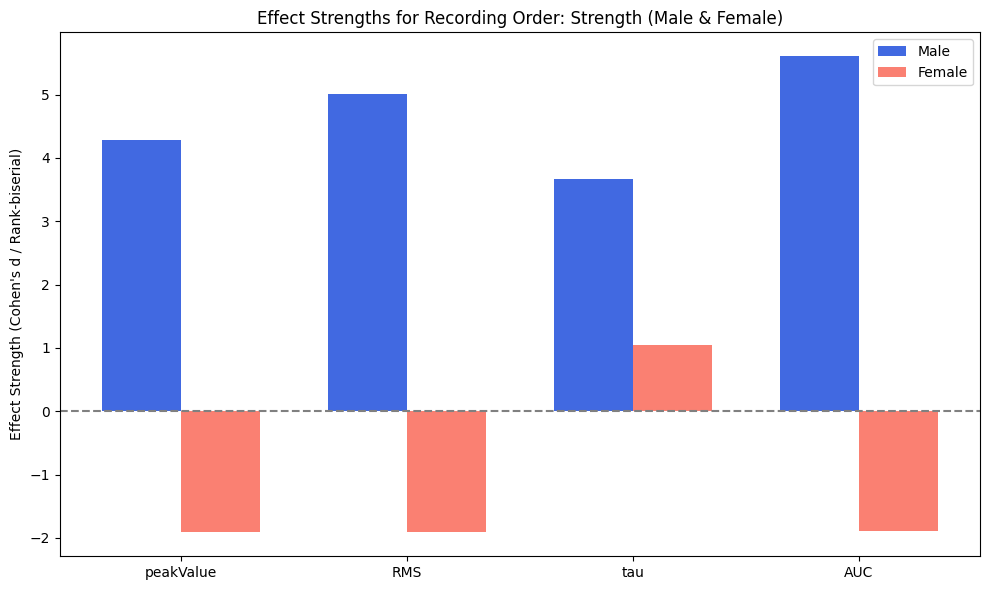

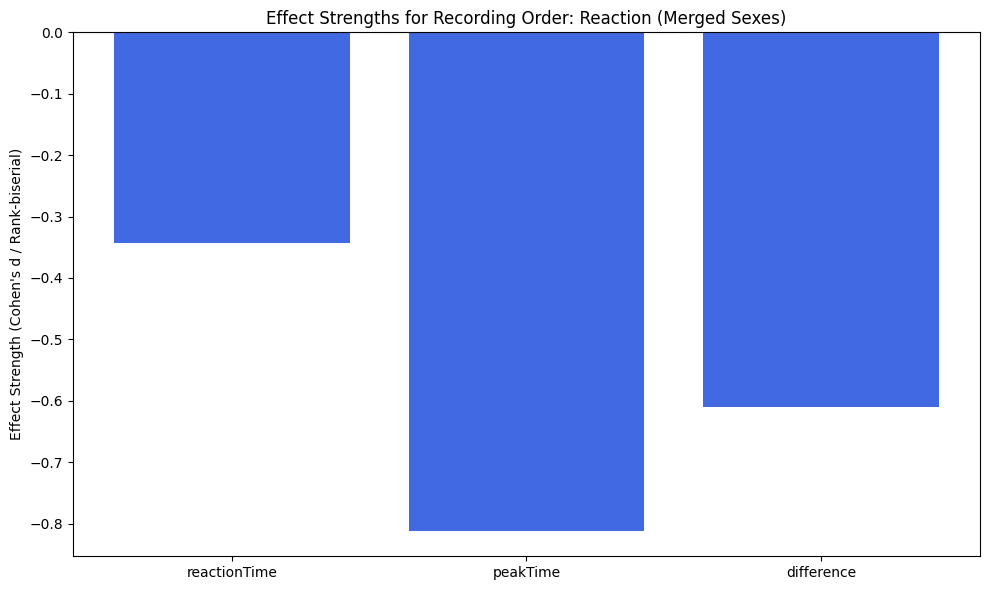

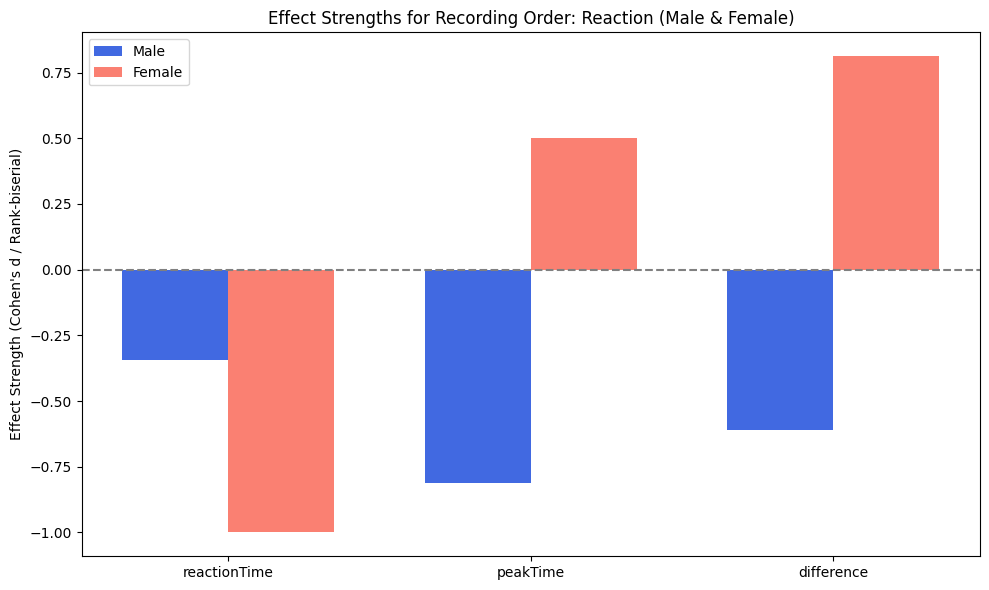

In [30]:
# Plot effect strengths from effect_strength_dicts, one plot per dictionary.
# If both male and female are present, plot them together in the same figure.
# If split is False, plot both merged and split-by-sex results for reference.

import matplotlib.pyplot as plt
import numpy as np

for metric_type in ['strength', 'reaction']:
    male_key = f"{metric_type}_male"
    female_key = f"{metric_type}_female"
    merged_key = f"{metric_type}_merged"

    # Plot merged
    if merged_key in effect_strength_dicts:
        metrics = list(effect_strength_dicts[merged_key].keys())
        values = list(effect_strength_dicts[merged_key].values())
        plt.figure(figsize=(10, 6))
        plt.bar(metrics, values, color='royalblue')
        plt.axhline(0, color='gray', linestyle='--')
        plt.xticks()
        plt.ylabel("Effect Strength (Cohen's d / Rank-biserial)")
        plt.title(f"Effect Strengths for Recording Order: {metric_type.title()} (Merged Sexes)")
        plt.tight_layout()
        plt.show()

    # If split-by-sex results exist, plot them together for reference
    if male_key in effect_strength_dicts and female_key in effect_strength_dicts:
        metrics = list(effect_strength_dicts[male_key].keys())
        male_values = list(effect_strength_dicts[male_key].values())
        female_values = list(effect_strength_dicts[female_key].values())
        x = np.arange(len(metrics))
        bar_width = 0.35

        plt.figure(figsize=(10, 6))
        plt.bar(x - bar_width/2, male_values, width=bar_width, label='Male', color='royalblue')
        plt.bar(x + bar_width/2, female_values, width=bar_width, label='Female', color='salmon')
        plt.axhline(0, color='gray', linestyle='--')
        plt.xticks(x, metrics)
        plt.ylabel("Effect Strength (Cohen's d / Rank-biserial)")
        plt.title(f"Effect Strengths for Recording Order: {metric_type.title()} (Male & Female)")
        plt.legend()
        plt.tight_layout()
        plt.show()

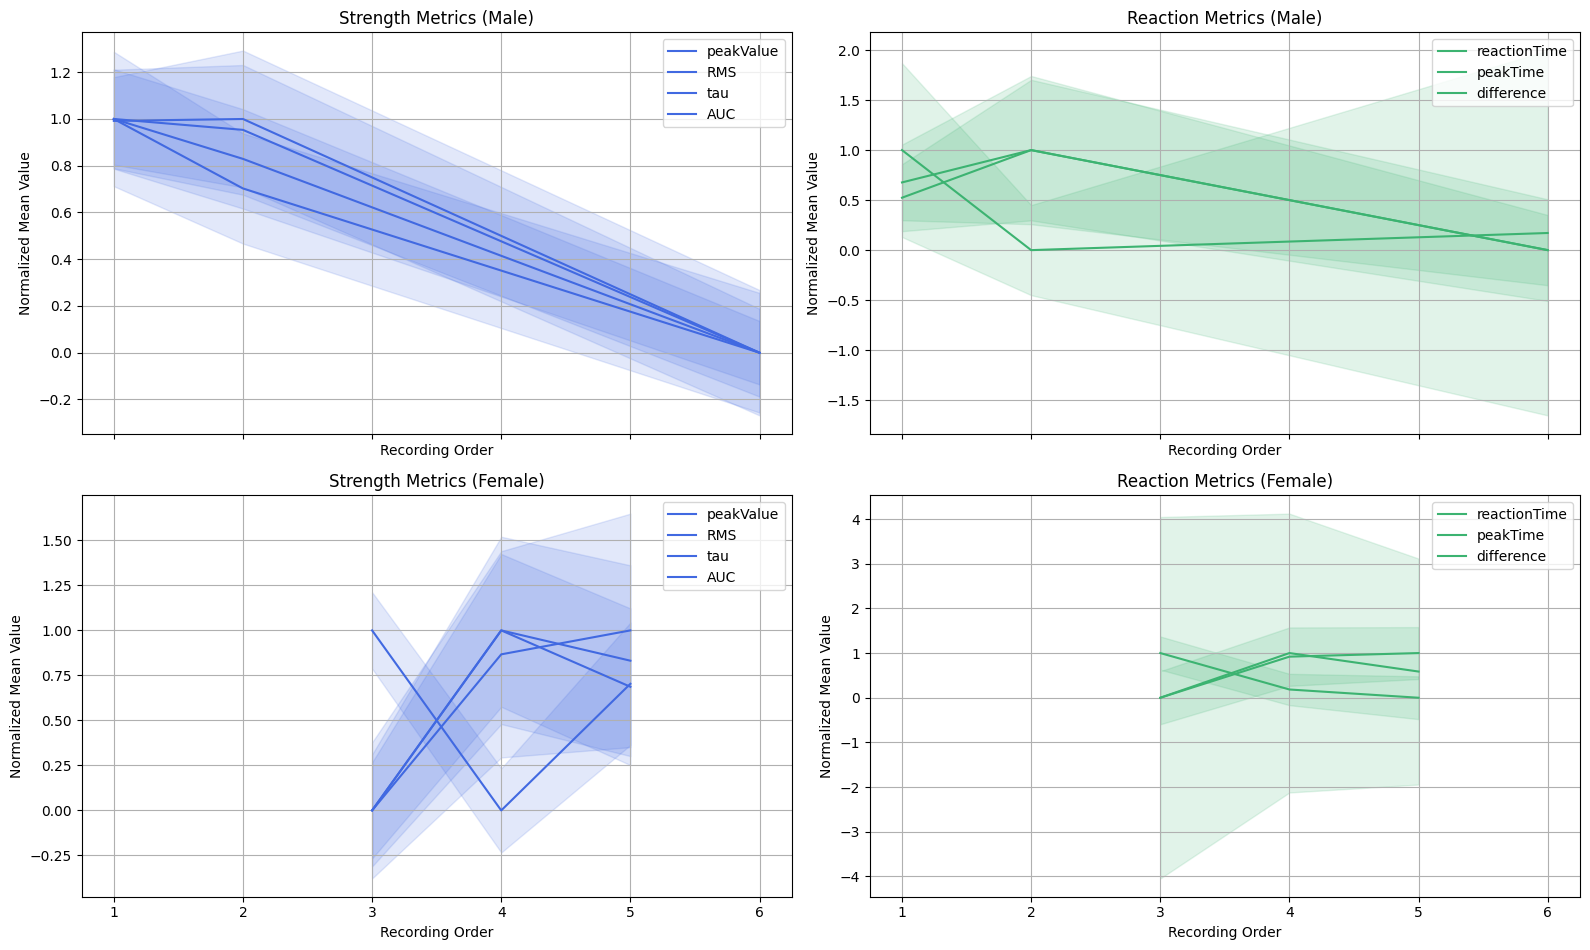

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Plot normalized lineplots for recording order effect, split by sex and metric type (4 subplots)
strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

df = dfs['RESULTS_MTT_MERGED_DATE'].copy()
df['animal_num'] = df['animal'].apply(lambda x: int(''.join(filter(str.isdigit, x))) if isinstance(x, str) and x.lower().startswith('animal') else np.nan)
df = df[df['animal_num'].isin(recording_order)]
df['rec_order'] = df['animal_num'].apply(lambda x: recording_order.index(x) if x in recording_order else np.nan)

fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

sexes = ['male', 'female']
metric_types = [
    (strength_metrics, "Strength Metrics", "royalblue"),
    (reaction_metrics, "Reaction Metrics", "mediumseagreen")
]

for row, sex in enumerate(sexes):
    for col, (metrics, title, color) in enumerate(metric_types):
        ax = axes[row, col]
        df_sex = df[df['sex'] == sex]
        for var in metrics:
            means = df_sex.groupby('rec_order')[var].mean()
            stds = df_sex.groupby('rec_order')[var].std()
            min_val = means.min()
            max_val = means.max()
            norm_means = (means - min_val) / (max_val - min_val + 1e-8)
            norm_stds = stds / (max_val - min_val + 1e-8)
            # Make x axis 1-indexed
            x_vals = norm_means.index + 1
            ax.plot(x_vals, norm_means.values, label=var, linestyle='-', color=color)
            ax.fill_between(x_vals, norm_means.values-norm_stds.values, norm_means.values+norm_stds.values, color=color, alpha=0.15)
        ax.set_title(f"{title} ({sex.capitalize()})")
        ax.set_xlabel("Recording Order")
        ax.set_ylabel("Normalized Mean Value")
        ax.legend(loc='upper right')
        ax.grid(True)

# plt.suptitle("Normalized Recording Order Effect\nStrength & Reaction Metrics, Split by Sex (4 plots)")
plt.tight_layout(rect=[0, 0, 1, 0.96])

## Summary: Effect Strength for Recording Order

### Strength Metrics (Split by Sex)
| Metric    | Sex    | Effect Strength | Value   | Comparison (rec_order) | Interpretation |
|-----------|--------|-----------------|---------|------------------------|----------------|
| peakValue | male   | Cohen's d       | 4.289   | 0 vs 5                 | Very strong increase for males from first to last recorded animal |
| RMS       | male   | Cohen's d       | 5.011   | 0 vs 5                 | Very strong increase for males |
| tau       | male   | Cohen's d       | 3.674   | 0 vs 5                 | Strong increase for males |
| AUC       | male   | Cohen's d       | 5.608   | 0 vs 5                 | Very strong increase for males |
| peakValue | female | Cohen's d       | -1.903  | 2 vs 4                 | Strong decrease for females from animal 2 to 4 |
| RMS       | female | Cohen's d       | -1.914  | 2 vs 4                 | Strong decrease for females |
| tau       | female | Cohen's d       | 1.047   | 2 vs 4                 | Moderate increase for females |
| AUC       | female | Cohen's d       | -1.884  | 2 vs 4                 | Strong decrease for females |

**Interpretation:**  
Recording order has a strong and opposite effect on strength metrics for males (increase) and females (decrease), except tau in females.

---

### Reaction Metrics (Merged Sexes)
| Metric        | Effect Strength | Value   | Comparison (rec_order) | Interpretation |
|---------------|----------------|---------|------------------------|----------------|
| reactionTime  | Rank-biserial  | -0.344  | 0 vs 5                 | Moderate decrease in reaction time for later recorded animals |
| peakTime      | Rank-biserial  | -0.812  | 0 vs 5                 | Strong decrease in peak time |
| difference    | Rank-biserial  | -0.609  | 0 vs 5                 | Moderate decrease in difference |

---

### Reaction Metrics (Split by Sex)
| Metric        | Sex    | Effect Strength | Value   | Comparison (rec_order) | Interpretation |
|---------------|--------|-----------------|---------|------------------------|----------------|
| reactionTime  | male   | Rank-biserial   | -0.344  | 0 vs 5                 | Moderate decrease for males |
| peakTime      | male   | Rank-biserial   | -0.812  | 0 vs 5                 | Strong decrease for males |
| difference    | male   | Rank-biserial   | -0.609  | 0 vs 5                 | Moderate decrease for males |
| reactionTime  | female | Rank-biserial   | -1.000  | 2 vs 4                 | Very strong decrease for females |
| peakTime      | female | Rank-biserial   | 0.500   | 2 vs 4                 | Moderate increase for females |
| difference    | female | Rank-biserial   | 0.812   | 2 vs 4                 | Strong increase for females |

**Interpretation:**  
Recording order affects reaction metrics differently for males and females. Males show decreased reaction metrics with later recording, while females show mixed effects (strong decrease in reactionTime, increase in peakTime and difference).

---

### Overall
- **Recording order has a strong, sex-dependent effect on both strength and reaction metrics.**
- **Males:** Metrics generally increase (strength) or decrease (reaction) with later recording.
- **Females:** Metrics generally decrease (strength), but reaction metrics show mixed directions.
- **Merged sexes:** Effects are generally negative, but this masks the opposite directions seen when split by sex.

**Recommendation:**  
Always consider sex when analyzing recording order effects, as the direction and magnitude of effects differ substantially between males and females.

---

In [32]:
strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

df_exp = dfs['RESULTS_MTT_MERGED_DATE']

print("Effect of experiment type on strength metrics:")
if split_strength:
    for sex in ['male', 'female']:
        df_sex = df_exp[df_exp['sex'] == sex]
        print(f"\n(Split by sex: {sex})")
        for var in strength_metrics:
            if var not in df_sex.columns:
                raise ValueError(f"Variable '{var}' not found in DataFrame for {sex}")
            groups = [group[var].dropna().values for _, group in df_sex.groupby('experiment')]
            groups = [g for g in groups if len(g) > 1]
            if len(groups) < 2:
                raise ValueError(f"Not enough data to perform Kruskal-Wallis test for {var} ({sex})")
            stat, p = kruskal(*groups)
            if p < 0.05:
                print(f"{var} ({sex}): stat={stat:.3f}, p={p:.3g}")
else:
    for var in strength_metrics:
        if var not in df_exp.columns:
            raise ValueError(f"Variable '{var}' not found in DataFrame")
        groups = [group[var].dropna().values for _, group in df_exp.groupby('experiment')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) < 2:
            raise ValueError(f"Not enough data to perform Kruskal-Wallis test for {var}")
        stat, p = kruskal(*groups)
        if p < 0.05:
            print(f"{var}: stat={stat:.3f}, p={p:.3g}")

print("\nEffect of experiment type on reaction metrics:")
if split_reaction:
    for sex in ['male', 'female']:
        df_sex = df_exp[df_exp['sex'] == sex]
        print(f"\n(Split by sex: {sex})")
        for var in reaction_metrics:
            if var not in df_sex.columns:
                raise ValueError(f"Variable '{var}' not found in DataFrame for {sex}")
            groups = [group[var].dropna().values for _, group in df_sex.groupby('experiment')]
            groups = [g for g in groups if len(g) > 1]
            if len(groups) < 2:
                raise ValueError(f"Not enough data to perform Kruskal-Wallis test for {var} ({sex})")
            stat, p = kruskal(*groups)
            if p < 0.05:
                print(f"{var} ({sex}): stat={stat:.3f}, p={p:.3g}")
else:
    for var in reaction_metrics:
        if var not in df_exp.columns:
            raise ValueError(f"Variable '{var}' not found in DataFrame")
        groups = [group[var].dropna().values for _, group in df_exp.groupby('experiment')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) < 2:
            raise ValueError(f"Not enough data to perform Kruskal-Wallis test for {var}")
        stat, p = kruskal(*groups)
        if p < 0.05:
            print(f"{var}: stat={stat:.3f}, p={p:.3g}")

Effect of experiment type on strength metrics:

(Split by sex: male)

(Split by sex: female)

Effect of experiment type on reaction metrics:


In [33]:
strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

df_exp = dfs['RESULTS_MTT_MERGED_DATE']

def group_normality(groups):
    """Return True if all groups are normal (p > 0.05), False otherwise."""
    for g in groups:
        if len(g) < 3:
            return False
        _, p = shapiro(g)
        if p < 0.05:
            return False
    return True

print("Effect of experiment type on strength metrics:")
if split_strength:
    for sex in ['male', 'female']:
        df_sex = df_exp[df_exp['sex'] == sex]
        print(f"\n(Split by sex: {sex})")
        for var in strength_metrics:
            if var not in df_sex.columns:
                raise ValueError(f"Variable '{var}' not found in DataFrame for {sex}")
            groups = [group[var].dropna().values for _, group in df_sex.groupby('experiment')]
            groups = [g for g in groups if len(g) > 2]
            if len(groups) < 2:
                raise ValueError(f"Not enough data to test {var} across experiments ({sex})")
            if any(len(g) < 3 for g in groups):
                raise ValueError(f"One or more groups for {var} ({sex}) have fewer than 3 samples.")
            if group_normality(groups):
                stat, p = f_oneway(*groups)
                test_used = "ANOVA"
            else:
                stat, p = kruskal(*groups)
                test_used = "Kruskal-Wallis"
            if p < 0.05:
                print(f"{var} ({sex}): {test_used} stat={stat:.3f}, p={p:.3g}")
else:
    for var in strength_metrics:
        if var not in df_exp.columns:
            raise ValueError(f"Variable '{var}' not found in DataFrame")
        groups = [group[var].dropna().values for _, group in df_exp.groupby('experiment')]
        groups = [g for g in groups if len(g) > 2]
        if len(groups) < 2:
            raise ValueError(f"Not enough data to test {var} across experiments")
        if any(len(g) < 3 for g in groups):
            raise ValueError(f"One or more groups for {var} have fewer than 3 samples.")
        if group_normality(groups):
            stat, p = f_oneway(*groups)
            test_used = "ANOVA"
        else:
            stat, p = kruskal(*groups)
            test_used = "Kruskal-Wallis"
        if p < 0.05:
            print(f"{var}: {test_used} stat={stat:.3f}, p={p:.3g}")

print("\nEffect of experiment type on reaction metrics:")
if split_reaction:
    for sex in ['male', 'female']:
        df_sex = df_exp[df_exp['sex'] == sex]
        print(f"\n(Split by sex: {sex})")
        for var in reaction_metrics:
            if var not in df_sex.columns:
                raise ValueError(f"Variable '{var}' not found in DataFrame for {sex}")
            groups = [group[var].dropna().values for _, group in df_sex.groupby('experiment')]
            groups = [g for g in groups if len(g) > 2]
            if len(groups) < 2:
                raise ValueError(f"Not enough data to test {var} across experiments ({sex})")
            if any(len(g) < 3 for g in groups):
                raise ValueError(f"One or more groups for {var} ({sex}) have fewer than 3 samples.")
            if group_normality(groups):
                stat, p = f_oneway(*groups)
                test_used = "ANOVA"
            else:
                stat, p = kruskal(*groups)
                test_used = "Kruskal-Wallis"
            if p < 0.05:
                print(f"{var} ({sex}): {test_used} stat={stat:.3f}, p={p:.3g}")
else:
    for var in reaction_metrics:
        if var not in df_exp.columns:
            raise ValueError(f"Variable '{var}' not found in DataFrame")
        groups = [group[var].dropna().values for _, group in df_exp.groupby('experiment')]
        groups = [g for g in groups if len(g) > 2]
        if len(groups) < 2:
            raise ValueError(f"Not enough data to test {var} across experiments")
        if any(len(g) < 3 for g in groups):
            raise ValueError(f"One or more groups for {var} have fewer than 3 samples.")
        if group_normality(groups):
            stat, p = f_oneway(*groups)
            test_used = "ANOVA"
        else:
            stat, p = kruskal(*groups)
            test_used = "Kruskal-Wallis"
        if p < 0.05:
            print(f"{var}: {test_used} stat={stat:.3f}, p={p:.3g}")

Effect of experiment type on strength metrics:

(Split by sex: male)

(Split by sex: female)

Effect of experiment type on reaction metrics:


In [34]:
# ...existing code...

from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Only run post hoc if ANOVA was significant for reactionTime
if 'reactionTime' in df_exp.columns:
    # Drop NaNs and get relevant columns
    posthoc_df = df_exp[['experiment', 'reactionTime']].dropna()
    # Tukey HSD
    tukey = pairwise_tukeyhsd(posthoc_df['reactionTime'], posthoc_df['experiment'], alpha=0.05)
    print("\nTukey HSD post hoc for reactionTime by experiment:")
    print(tukey.summary())
    # Effect direction: print group means
    means = posthoc_df.groupby('experiment')['reactionTime'].mean()
    print("Means by experiment:", means.to_dict())
# ...existing code...


Tukey HSD post hoc for reactionTime by experiment:
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
    ASR_control       gap_depth  -0.6593 0.8852 -2.2539 0.9354  False
    ASR_control gap_duration_10  -0.3167 0.9981 -1.9113 1.2779  False
    ASR_control gap_duration_20  -0.4907 0.9742 -2.0854 1.1039  False
    ASR_control  gap_duration_4   -0.337 0.9972 -1.9316 1.2576  False
    ASR_control gap_duration_50  -0.2926 0.9989 -1.8872  1.302  False
    ASR_control  gap_duration_8  -0.1815    1.0 -1.7761 1.4131  False
    ASR_control   tone_in_noise  -1.5593 0.0593 -3.1539 0.0354  False
      gap_depth gap_duration_10   0.3426 0.9969  -1.252 1.9372  False
      gap_depth gap_duration_20   0.1685    1.0 -1.4261 1.7631  False
      gap_depth  gap_duration_4   0.3222 0.9979 -1.2724 1.9168  False
      gap_depth gap_duration_50   0.36

In [35]:
strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

df_exp = dfs['RESULTS_MTT_MERGED_DATE']

def group_normality(groups):
    """Return True if all groups are normal (p > 0.05), False otherwise."""
    for g in groups:
        if len(g) < 3:
            return False
        _, p = shapiro(g)
        if p < 0.05:
            return False
    return True

print("Effect of experiment type on strength metrics:")
if split_strength:
    for sex in ['male', 'female']:
        print(f"\nEffect of experiment type on strength metrics ({sex}):")
        df_sex = df_exp[df_exp['sex'] == sex]
        for var in strength_metrics:
            if var not in df_sex.columns:
                raise ValueError(f"Variable '{var}' not found for {sex}")
            groups = [group[var].dropna().values for _, group in df_sex.groupby('experiment')]
            groups = [g for g in groups if len(g) > 2]
            if len(groups) < 2:
                raise ValueError(f"Not enough data to perform statistical test for {var} ({sex})")
            if any(len(g) < 3 for g in groups):
                raise ValueError(f"One or more groups for {var} ({sex}) have fewer than 3 samples.")
            if group_normality(groups):
                stat, p = f_oneway(*groups)
                test_used = "ANOVA"
            else:
                stat, p = kruskal(*groups)
                test_used = "Kruskal-Wallis"
            if p < 0.05:
                print(f"{var}: {test_used} stat={stat:.3f}, p={p:.3g}")
else:
    print("\nEffect of experiment type on strength metrics (merged sexes):")
    for var in strength_metrics:
        if var not in df_exp.columns:
            raise ValueError(f"Variable '{var}' not found in DataFrame")
        groups = [group[var].dropna().values for _, group in df_exp.groupby('experiment')]
        groups = [g for g in groups if len(g) > 2]
        if len(groups) < 2:
            raise ValueError(f"Not enough data to perform statistical test for {var}")
        if any(len(g) < 3 for g in groups):
            raise ValueError(f"One or more groups for {var} have fewer than 3 samples.")
        if group_normality(groups):
            stat, p = f_oneway(*groups)
            test_used = "ANOVA"
        else:
            stat, p = kruskal(*groups)
            test_used = "Kruskal-Wallis"
        if p < 0.05:
            print(f"{var}: {test_used} stat={stat:.3f}, p={p:.3g}")

print("\nEffect of experiment type on reaction metrics:")
if split_reaction:
    for sex in ['male', 'female']:
        print(f"\nEffect of experiment type on reaction metrics ({sex}):")
        df_sex = df_exp[df_exp['sex'] == sex]
        for var in reaction_metrics:
            if var not in df_sex.columns:
                raise ValueError(f"Variable '{var}' not found for {sex}")
            groups = [group[var].dropna().values for _, group in df_sex.groupby('experiment')]
            groups = [g for g in groups if len(g) > 2]
            if len(groups) < 2:
                raise ValueError(f"Not enough data to perform statistical test for {var} ({sex})")
            if any(len(g) < 3 for g in groups):
                raise ValueError(f"One or more groups for {var} ({sex}) have fewer than 3 samples.")
            if group_normality(groups):
                stat, p = f_oneway(*groups)
                test_used = "ANOVA"
            else:
                stat, p = kruskal(*groups)
                test_used = "Kruskal-Wallis"
            if p < 0.05:
                print(f"{var}: {test_used} stat={stat:.3f}, p={p:.3g}")
            if p < 0.05 and test_used == "ANOVA":
                posthoc_df = df_sex[['experiment', var]].dropna()
                tukey = pairwise_tukeyhsd(posthoc_df[var], posthoc_df['experiment'], alpha=0.05)
                print(f"\nTukey HSD post hoc for {var} by experiment ({sex}):")
                print(tukey.summary())
                means = posthoc_df.groupby('experiment')[var].mean()
else:
    print("\nEffect of experiment type on reaction metrics (merged sexes):")
    for var in reaction_metrics:
        if var not in df_exp.columns:
            raise ValueError(f"Variable '{var}' not found in DataFrame")
        groups = [group[var].dropna().values for _, group in df_exp.groupby('experiment')]
        groups = [g for g in groups if len(g) > 2]
        if len(groups) < 2:
            raise ValueError(f"Not enough data to perform statistical test for {var}")
        if any(len(g) < 3 for g in groups):
            raise ValueError(f"One or more groups for {var} have fewer than 3 samples.")
        if group_normality(groups):
            stat, p = f_oneway(*groups)
            test_used = "ANOVA"
        else:
            stat, p = kruskal(*groups)
            test_used = "Kruskal-Wallis"
        if p < 0.05:
            print(f"{var}: {test_used} stat={stat:.3f}, p={p:.3g}")
        if p < 0.05 and test_used == "ANOVA":
            posthoc_df = df_exp[['experiment', var]].dropna()
            tukey = pairwise_tukeyhsd(posthoc_df[var], posthoc_df['experiment'], alpha=0.05)
            print(f"\nTukey HSD post hoc for {var} by experiment (merged sexes):")

Effect of experiment type on strength metrics:

Effect of experiment type on strength metrics (male):

Effect of experiment type on strength metrics (female):

Effect of experiment type on reaction metrics:

Effect of experiment type on reaction metrics (merged sexes):


### -> No effect of experiment

---

In [36]:
import re
from scipy.stats import kruskal

df = dfs['RESULTS_MTT_MERGED_DATE']

def extract_number(exp_name, prefix):
    match = re.search(fr"{prefix}_(\d+)", str(exp_name))
    return int(match.group(1)) if match else np.nan

def test_gap_offset(df, variables, split, metric_type, prefix, num_col):
    # Only run if there are experiments with this prefix
    if not any(df['experiment'].str.startswith(prefix)):
        print(f"\nNo experiments found for {prefix}, skipping.")
        return
    if split:
        for sex in ['male', 'female']:
            df_sex = df[df['sex'] == sex]
            sub_df = df_sex[df_sex['experiment'].str.startswith(prefix)].copy()
            if sub_df.empty:
                print(f"\nNo {prefix} experiments for sex {sex}, skipping.")
                continue
            sub_df[num_col] = sub_df['experiment'].apply(lambda x: extract_number(x, prefix))
            print(f"\nEffect of {prefix.replace('_', ' ')} length on {metric_type} metrics ({sex}):")
            for var in variables:
                if var not in sub_df.columns:
                    print(f"Variable {var} not found in {prefix} df for {sex}, skipping.")
                    continue
                groups = [group[var].dropna().values for _, group in sub_df.groupby(num_col)]
                groups = [g for g in groups if len(g) > 2]
                if len(groups) < 2:
                    print(f"Not enough data to perform statistical test for {var} in {prefix} df ({sex}), skipping.")
                    continue
                stat, p = kruskal(*groups)
                if p < 0.05:
                    print(f"{var} ({sex}): Kruskal-Wallis stat={stat:.3f}, p={p:.3g}")
    else:
        sub_df = df[df['experiment'].str.startswith(prefix)].copy()
        if sub_df.empty:
            print(f"\nNo {prefix} experiments found, skipping.")
            return
        sub_df[num_col] = sub_df['experiment'].apply(lambda x: extract_number(x, prefix))
        print(f"\nEffect of {prefix.replace('_', ' ')} length on {metric_type} metrics (merged sexes):")
        for var in variables:
            if var not in sub_df.columns:
                print(f"Variable {var} not found in {prefix} df, skipping.")
                continue
            groups = [group[var].dropna().values for _, group in sub_df.groupby(num_col)]
            groups = [g for g in groups if len(g) > 2]
            if len(groups) < 2:
                print(f"Not enough data to perform statistical test for {var} in {prefix} df, skipping.")
                continue
            stat, p = kruskal(*groups)
            if p < 0.05:
                print(f"{var}: Kruskal-Wallis stat={stat:.3f}, p={p:.3g}")

# Split logic for strength and reaction metrics
test_gap_offset(df, strength_metrics, split_strength, "strength", "gap_duration", "gap_num")
test_gap_offset(df, reaction_metrics, split_reaction, "reaction", "gap_duration", "gap_num")
test_gap_offset(df, strength_metrics, split_strength, "strength", "offset_PPI", "offset_num")
test_gap_offset(df, reaction_metrics, split_reaction, "reaction", "offset_PPI", "offset_num")


Effect of gap duration length on strength metrics (male):

Effect of gap duration length on strength metrics (female):

Effect of gap duration length on reaction metrics (merged sexes):

No experiments found for offset_PPI, skipping.

No experiments found for offset_PPI, skipping.


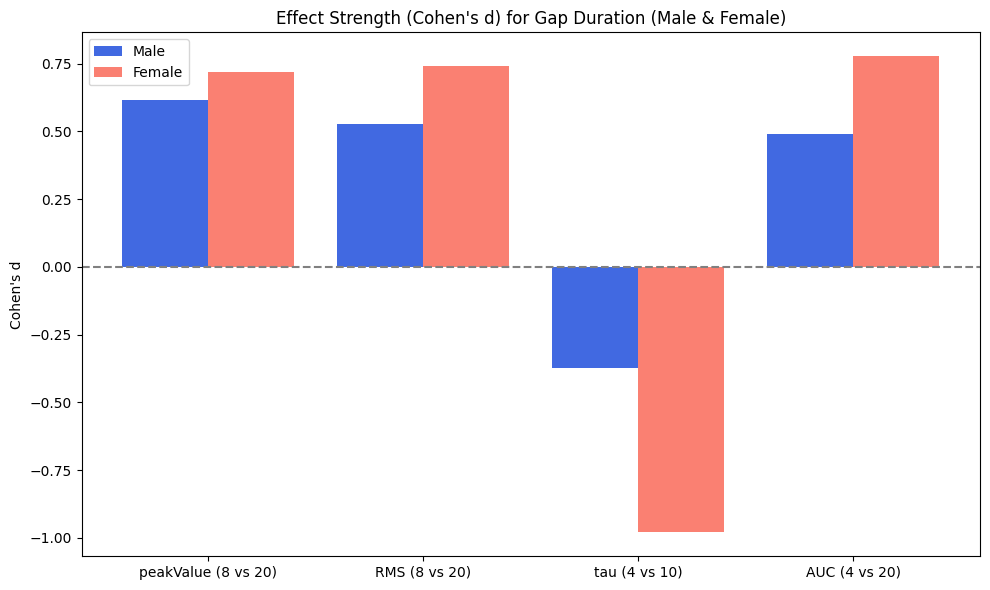

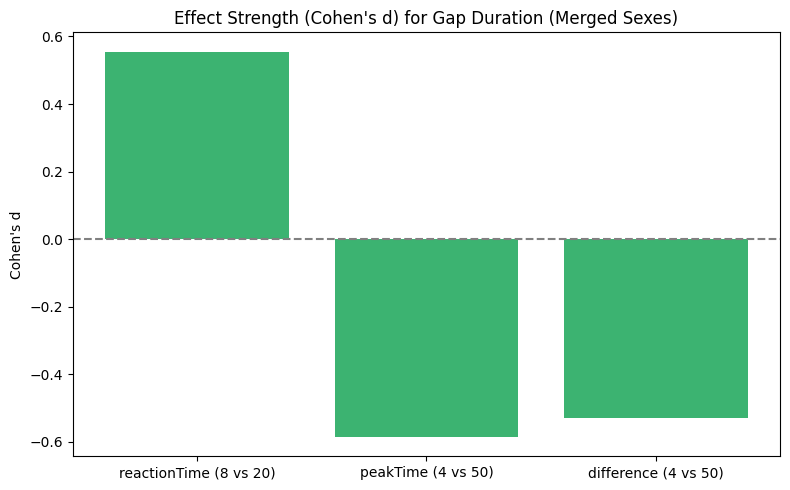

No offset_PPI experiments for sex male or not enough groups, skipping.
No offset_PPI experiments for sex female or not enough groups, skipping.
No offset_PPI experiments found or not enough groups, skipping.


In [37]:
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import numpy as np

def plot_gap_offset_effects(df, variables, split, metric_type, prefix, num_col, color):
    if split:
        for sex in ['male', 'female']:
            sub_df = df[df['sex'] == sex]
            sub_df = sub_df[sub_df['experiment'].str.startswith(prefix)].copy()
            # Add this line to extract the number column
            sub_df[num_col] = sub_df['experiment'].str.extract(fr'{prefix}_(\d+)').astype(float)
            if sub_df.empty or sub_df[num_col].nunique() < 2:
                print(f"No {prefix} experiments for sex {sex} or not enough groups, skipping.")
                continue
            # ...existing code...
    else:
        sub_df = df[df['experiment'].str.startswith(prefix)].copy()
        # Add this line to extract the number column
        sub_df[num_col] = sub_df['experiment'].str.extract(fr'{prefix}_(\d+)').astype(float)
        if sub_df.empty or sub_df[num_col].nunique() < 2:
            print(f"No {prefix} experiments found or not enough groups, skipping.")
            return
        # ...existing code...

def plot_gap_offset_effects(df, variables, split, metric_type, prefix, num_col, color):
    import matplotlib.pyplot as plt
    import numpy as np
    import scikit_posthocs as sp

    if split:
        all_results = {'male': [], 'female': []}
        for sex in ['male', 'female']:
            sub_df = df[df['sex'] == sex]
            sub_df = sub_df[sub_df['experiment'].str.startswith(prefix)].copy()
            sub_df[num_col] = sub_df['experiment'].str.extract(fr'{prefix}_(\d+)').astype(float)
            if sub_df.empty or sub_df[num_col].nunique() < 2:
                print(f"No {prefix} experiments for sex {sex} or not enough groups, skipping.")
                continue
            for var in variables:
                if var not in sub_df.columns or sub_df[num_col].nunique() < 2:
                    continue
                dunn = sp.posthoc_dunn(sub_df, val_col=var, group_col=num_col, p_adjust='bonferroni')
                means = sub_df.groupby(num_col)[var].mean()
                idx = np.unravel_index(np.abs(means.values[:, None] - means.values).argmax(), means.shape*2)
                g1, g2 = means.index[idx[0]], means.index[idx[1]]
                vals1 = sub_df[sub_df[num_col] == g1][var].dropna()
                vals2 = sub_df[sub_df[num_col] == g2][var].dropna()
                pooled_std = np.sqrt(((len(vals1)-1)*np.std(vals1, ddof=1)**2 + (len(vals2)-1)*np.std(vals2, ddof=1)**2) / (len(vals1)+len(vals2)-2)) if (len(vals1)+len(vals2)-2) > 0 else np.nan
                cohen_d_val = (np.mean(vals1) - np.mean(vals2)) / pooled_std if pooled_std > 0 else np.nan
                all_results[sex].append({'variable': var, 'group1': g1, 'group2': g2, 'cohen_d': cohen_d_val})
        # Plot both sexes together
        if all_results['male'] or all_results['female']:
            labels = [f"{r['variable']} ({int(r['group1'])} vs {int(r['group2'])})" for r in all_results['male']]
            male_effects = [r['cohen_d'] for r in all_results['male']]
            female_effects = [r['cohen_d'] for r in all_results['female']]
            x = np.arange(len(labels))
            plt.figure(figsize=(10, 6))
            plt.bar(x - 0.2, male_effects, width=0.4, label='Male', color='royalblue')
            plt.bar(x + 0.2, female_effects, width=0.4, label='Female', color='salmon')
            plt.xticks(x, labels)
            plt.axhline(0, color='gray', linestyle='--')
            plt.title(f'Effect Strength (Cohen\'s d) for {prefix.replace("_", " ").title()} (Male & Female)')
            plt.ylabel('Cohen\'s d')
            plt.legend()
            plt.tight_layout()
            plt.show()
    else:
        sub_df = df[df['experiment'].str.startswith(prefix)].copy()
        sub_df[num_col] = sub_df['experiment'].str.extract(fr'{prefix}_(\d+)').astype(float)
        if sub_df.empty or sub_df[num_col].nunique() < 2:
            print(f"No {prefix} experiments found or not enough groups, skipping.")
            return
        results = []
        for var in variables:
            if var not in sub_df.columns or sub_df[num_col].nunique() < 2:
                continue
            dunn = sp.posthoc_dunn(sub_df, val_col=var, group_col=num_col, p_adjust='bonferroni')
            means = sub_df.groupby(num_col)[var].mean()
            idx = np.unravel_index(np.abs(means.values[:, None] - means.values).argmax(), means.shape*2)
            g1, g2 = means.index[idx[0]], means.index[idx[1]]
            vals1 = sub_df[sub_df[num_col] == g1][var].dropna()
            vals2 = sub_df[sub_df[num_col] == g2][var].dropna()
            pooled_std = np.sqrt(((len(vals1)-1)*np.std(vals1, ddof=1)**2 + (len(vals2)-1)*np.std(vals2, ddof=1)**2) / (len(vals1)+len(vals2)-2)) if (len(vals1)+len(vals2)-2) > 0 else np.nan
            cohen_d_val = (np.mean(vals1) - np.mean(vals2)) / pooled_std if pooled_std > 0 else np.nan
            results.append({'variable': var, 'group1': g1, 'group2': g2, 'cohen_d': cohen_d_val})
        labels = [f"{r['variable']} ({int(r['group1'])} vs {int(r['group2'])})" for r in results]
        effects = [r['cohen_d'] for r in results]
        if effects:
            plt.figure(figsize=(8, 5))
            plt.bar(labels, effects, color=color)
            plt.axhline(0, color='gray', linestyle='--')
            plt.title(f'Effect Strength (Cohen\'s d) for {prefix.replace("_", " ").title()} (Merged Sexes)')
            plt.ylabel('Cohen\'s d')
            plt.tight_layout()
            plt.show()

# Usage for gap_duration and offset_PPI
plot_gap_offset_effects(df, strength_metrics, split_strength, "strength", "gap_duration", "gap_num", "mediumseagreen")
plot_gap_offset_effects(df, reaction_metrics, split_reaction, "reaction", "gap_duration", "gap_num", "mediumseagreen")
plot_gap_offset_effects(df, strength_metrics, split_strength, "strength", "offset_PPI", "offset_num", "royalblue")
plot_gap_offset_effects(df, reaction_metrics, split_reaction, "reaction", "offset_PPI", "offset_num", "royalblue")

---